In [1]:
import numpy as np
import matplotlib.pylab as plt
import corner
import glob
from PTMCMCSampler import PTMCMCSampler

%matplotlib inline

Do not have mpi4py package.
Do not have acor package


## Define the likelihood and posterior

Functions must read in parameter vector and output log-likelihood or log-prior. Usually easiest to use a class if you need to store some other data or parameters

In [2]:
class GaussianLikelihood(object):
    
    def __init__(self, ndim=2, pmin=-10, pmax=10):
        
        self.a = np.ones(ndim)*pmin
        self.b = np.ones(ndim)*pmax
        
        # get means
        self.mu = np.random.uniform(pmin, pmax, ndim)

        # ... and a positive definite, non-trivial covariance matrix.
        cov  = 0.5-np.random.rand(ndim**2).reshape((ndim, ndim))
        cov  = np.triu(cov)
        cov += cov.T - np.diag(cov.diagonal())
        self.cov  = np.dot(cov,cov)

        # Invert the covariance matrix first.
        self.icov = np.linalg.inv(self.cov)
        
    def lnlikefn(self, x):
        diff = x - self.mu
        return -np.dot(diff,np.dot(self.icov, diff))/2.0
    
    def lnpriorfn(self, x):
        
        if np.all(self.a <= x) and np.all(self.b >= x):
            return 0.0
        else:
            return -np.inf      


## Setup Gaussian model class

In [3]:
ndim = 20
pmin, pmax = 0.0, 10.0
glo = GaussianLikelihood(ndim=ndim, pmin=pmin, pmax=pmax)

## Setup sampler

Need to initalize the sample at ```p0``` and give an inital jump covariance matrix ```cov```.

In [4]:
# Set the start position and the covariance
p0 = np.random.uniform(pmin, pmax, ndim)
cov = np.eye(ndim) * 0.1**2

In [5]:
sampler = PTMCMCSampler.PTSampler(ndim, glo.lnlikefn, glo.lnpriorfn, np.copy(cov), outDir='./chains')

## Add custom jump

Can add custom jump in the following way

In [6]:
class UniformJump(object):
    
    def __init__(self, pmin, pmax):
        """Draw random parameters from pmin, pmax"""
        self.pmin = pmin
        self.pmax = pmax
        
    def jump(self, x, it, beta):
        """ 
        Function prototype must read in parameter vector x,
        sampler iteration number it, and inverse temperature beta
        """
        
        # log of forward-backward jump probability
        lqxy = 0
        
        # uniformly drawm parameters
        q = np.random.uniform(self.pmin, self.pmax, len(x))
        
        return q, lqxy

In [7]:
# add to jump proposal cycle
ujump = UniformJump(pmin, pmax)
sampler.addProposalToCycle(ujump.jump, 5)

## Run Sampler for 100000 steps

Different jump proposal weights are given as integers. For example we have used a weight of 20 for all three proposals here. That means that each will be used with a probability of 20/60 = 1/3.

In [8]:
sampler.sample(p0, 100000, burn=500, thin=1, covUpdate=500,
               SCAMweight=20, AMweight=20, DEweight=20)

Adding DE jump with weight 20
Finished 99.00 percent in 17.153649 s Acceptance rate = 0.344033
Run Complete


## Get jump statistics

Here you can track the acceptance rate of the different jump proposals used

(0.0, 1.1)

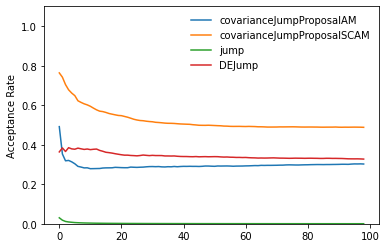

In [9]:
jumpfiles = glob.glob('chains/*jump.txt')
jumps = map(np.loadtxt, jumpfiles)
for ct, j in enumerate(jumps):
    plt.plot(j, label=jumpfiles[ct].split('/')[-1].split('_jump.txt')[0])
plt.legend(loc='best', frameon=False)
plt.ylabel('Acceptance Rate')
plt.ylim(0.0, 1.1)

## Get the data and plot the output

The output data has ndim + 4 columns. The first ndim columns are just the samples from the parameters, the ndim+1 column is the log-posterior, ndim+2 is the log-likelihood, ndim+3 is the acceptance rate, and ndim+4 is the parallel tempering swap acceptance rate for the T=1 chain.

In [10]:
data = np.loadtxt('chains/chain_1.txt')
chaint = data[:,:-4]

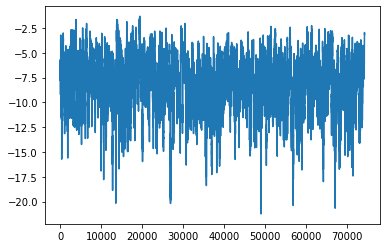

In [11]:
# throw out first 25% of chain as burn in 
burn = int(0.25*chaint.shape[0])
plt.plot(data[burn:,-4])

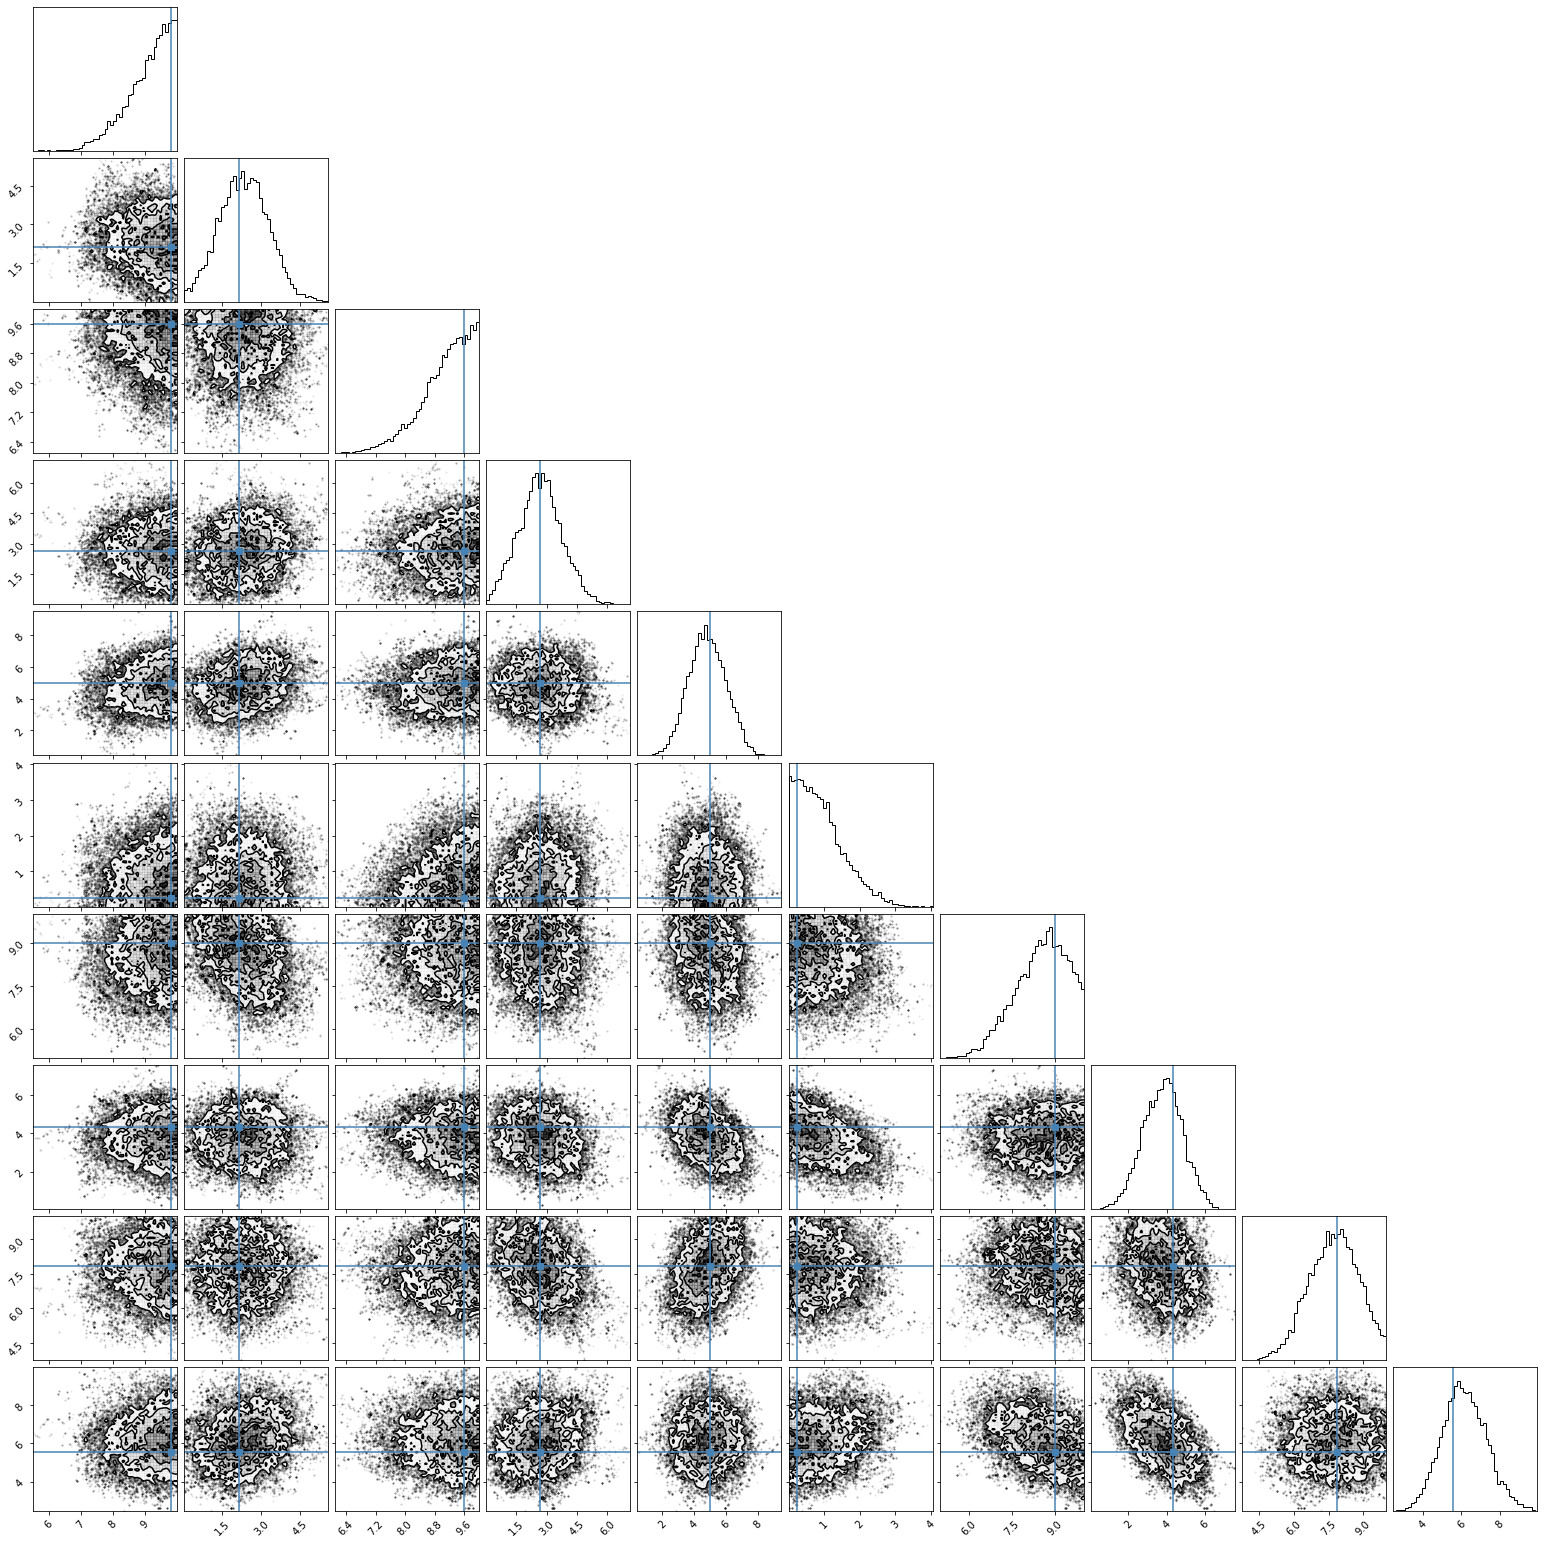

In [14]:
# get the true values and plot the posteriors for the first 10 parameters
truth = glo.mu
corner.corner(chaint[burn:,:10], bins=50, truths=truth[:10]);